## SetUp

In [2]:
!pip install validators
!pip install opencv-python

In [3]:
import typing
import string

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import os
import hashlib

import urllib.request
import urllib.parse

tf.__version__

'2.8.0'

### Hyper-Parameters

In [4]:
DEFAULT_BUILD_PARAMS = {
    'height': 31,
    'width': 200,
    'color': False,
    'filters': (64, 128, 256, 256, 512, 512, 512),
    'rnn_units': (128, 128),
    'dropout': 0.25,
    'rnn_steps_to_discard': 2,
    'pool_size': 2,
    'stn': True,
}

DEFAULT_ALPHABET = string.digits + string.ascii_lowercase

PRETRAINED_WEIGHTS = {
    'kurapan': {
        'alphabet': DEFAULT_ALPHABET,
        'build_params': DEFAULT_BUILD_PARAMS,
        'weights': {
            'notop': {
                'url':
                'https://github.com/faustomorales/keras-ocr/releases/download/v0.8.4/crnn_kurapan_notop.h5',
                'filename': 'crnn_kurapan_notop.h5',
                'sha256': '027fd2cced3cbea0c4f5894bb8e9e85bac04f11daf96b8fdcf1e4ee95dcf51b9'
            },
            'top': {
                'url':
                'https://github.com/faustomorales/keras-ocr/releases/download/v0.8.4/crnn_kurapan.h5',
                'filename': 'crnn_kurapan.h5',
                'sha256': 'a7d8086ac8f5c3d6a0a828f7d6fbabcaf815415dd125c32533013f85603be46d'
            }
        }
    }
}

## Utilities

In [5]:
def swish(x, beta=1):
    return x * keras.backend.sigmoid(beta * x)


keras.utils.get_custom_objects().update({'swish': keras.layers.Activation(swish)})


def _repeat(x, num_repeats):
    ones = tf.ones((1, num_repeats), dtype='int32')
    x = tf.reshape(x, shape=(-1, 1))
    x = tf.matmul(x, ones)
    return tf.reshape(x, [-1])


def _meshgrid(height, width):
    x_linspace = tf.linspace(-1., 1., width)
    y_linspace = tf.linspace(-1., 1., height)
    x_coordinates, y_coordinates = tf.meshgrid(x_linspace, y_linspace)
    x_coordinates = tf.reshape(x_coordinates, shape=(1, -1))
    y_coordinates = tf.reshape(y_coordinates, shape=(1, -1))
    ones = tf.ones_like(x_coordinates)
    indices_grid = tf.concat([x_coordinates, y_coordinates, ones], 0)
    return indices_grid


# pylint: disable=too-many-statements
def _transform(inputs):
    locnet_x, locnet_y = inputs
    output_size = locnet_x.shape[1:]
    batch_size = tf.shape(locnet_x)[0]
    height = tf.shape(locnet_x)[1]
    width = tf.shape(locnet_x)[2]
    num_channels = tf.shape(locnet_x)[3]

    locnet_y = tf.reshape(locnet_y, shape=(batch_size, 2, 3))

    locnet_y = tf.reshape(locnet_y, (-1, 2, 3))
    locnet_y = tf.cast(locnet_y, 'float32')

    output_height = output_size[0]
    output_width = output_size[1]
    indices_grid = _meshgrid(output_height, output_width)
    indices_grid = tf.expand_dims(indices_grid, 0)
    indices_grid = tf.reshape(indices_grid, [-1])  # flatten?
    indices_grid = tf.tile(indices_grid, tf.stack([batch_size]))
    indices_grid = tf.reshape(indices_grid, tf.stack([batch_size, 3, -1]))

    transformed_grid = tf.matmul(locnet_y, indices_grid)
    x_s = tf.slice(transformed_grid, [0, 0, 0], [-1, 1, -1])
    y_s = tf.slice(transformed_grid, [0, 1, 0], [-1, 1, -1])
    x = tf.reshape(x_s, [-1])
    y = tf.reshape(y_s, [-1])

    # Interpolate
    height_float = tf.cast(height, dtype='float32')
    width_float = tf.cast(width, dtype='float32')

    output_height = output_size[0]
    output_width = output_size[1]

    x = tf.cast(x, dtype='float32')
    y = tf.cast(y, dtype='float32')
    x = .5 * (x + 1.0) * width_float
    y = .5 * (y + 1.0) * height_float

    x0 = tf.cast(tf.floor(x), 'int32')
    x1 = x0 + 1
    y0 = tf.cast(tf.floor(y), 'int32')
    y1 = y0 + 1

    max_y = tf.cast(height - 1, dtype='int32')
    max_x = tf.cast(width - 1, dtype='int32')
    zero = tf.zeros([], dtype='int32')

    x0 = tf.clip_by_value(x0, zero, max_x)
    x1 = tf.clip_by_value(x1, zero, max_x)
    y0 = tf.clip_by_value(y0, zero, max_y)
    y1 = tf.clip_by_value(y1, zero, max_y)

    flat_image_dimensions = width * height
    pixels_batch = tf.range(batch_size) * flat_image_dimensions
    flat_output_dimensions = output_height * output_width
    base = _repeat(pixels_batch, flat_output_dimensions)
    base_y0 = base + y0 * width
    base_y1 = base + y1 * width
    indices_a = base_y0 + x0
    indices_b = base_y1 + x0
    indices_c = base_y0 + x1
    indices_d = base_y1 + x1

    flat_image = tf.reshape(locnet_x, shape=(-1, num_channels))
    flat_image = tf.cast(flat_image, dtype='float32')
    pixel_values_a = tf.gather(flat_image, indices_a)
    pixel_values_b = tf.gather(flat_image, indices_b)
    pixel_values_c = tf.gather(flat_image, indices_c)
    pixel_values_d = tf.gather(flat_image, indices_d)

    x0 = tf.cast(x0, 'float32')
    x1 = tf.cast(x1, 'float32')
    y0 = tf.cast(y0, 'float32')
    y1 = tf.cast(y1, 'float32')

    area_a = tf.expand_dims(((x1 - x) * (y1 - y)), 1)
    area_b = tf.expand_dims(((x1 - x) * (y - y0)), 1)
    area_c = tf.expand_dims(((x - x0) * (y1 - y)), 1)
    area_d = tf.expand_dims(((x - x0) * (y - y0)), 1)
    transformed_image = tf.add_n([
        area_a * pixel_values_a, area_b * pixel_values_b, area_c * pixel_values_c,
        area_d * pixel_values_d
    ])
    # Finished interpolation

    transformed_image = tf.reshape(transformed_image,
                                   shape=(batch_size, output_height, output_width, num_channels))
    return transformed_image

## Create Model

In [6]:
def CTCDecoder():
    def decoder(y_pred):
        input_shape = tf.keras.backend.shape(y_pred)
        input_length = tf.ones(shape=input_shape[0]) * tf.keras.backend.cast(
            input_shape[1], 'float32')
        unpadded = tf.keras.backend.ctc_decode(y_pred, input_length)[0][0]
        unpadded_shape = tf.keras.backend.shape(unpadded)
        padded = tf.pad(unpadded,
                        paddings=[[0, 0], [0, input_shape[1] - unpadded_shape[1]]],
                        constant_values=-1)
        return padded

    return tf.keras.layers.Lambda(decoder, name='decode')

In [7]:
def build_model(alphabet,
                height,
                width,
                color,
                filters,
                rnn_units,
                dropout,
                rnn_steps_to_discard,
                pool_size,
                stn=True):
    """Build a Keras CRNN model for character recognition.
    Args:
        height: The height of cropped images
        width: The width of cropped images
        color: Whether the inputs should be in color (RGB)
        filters: The number of filters to use for each of the 7 convolutional layers
        rnn_units: The number of units for each of the RNN layers
        dropout: The dropout to use for the final layer
        rnn_steps_to_discard: The number of initial RNN steps to discard
        pool_size: The size of the pooling steps
        stn: Whether to add a Spatial Transformer layer
    """
    assert len(filters) == 7, '7 CNN filters must be provided.'
    assert len(rnn_units) == 2, '2 RNN filters must be provided.'
    inputs = keras.layers.Input((height, width, 3 if color else 1), name='input', batch_size=1)
    x = keras.layers.Permute((2, 1, 3))(inputs)
    x = keras.layers.Lambda(lambda x: x[:, :, ::-1])(x)
    x = keras.layers.Conv2D(filters[0], (3, 3), activation='relu', padding='same', name='conv_1')(x)
    x = keras.layers.Conv2D(filters[1], (3, 3), activation='relu', padding='same', name='conv_2')(x)
    x = keras.layers.Conv2D(filters[2], (3, 3), activation='relu', padding='same', name='conv_3')(x)
    x = keras.layers.BatchNormalization(name='bn_3')(x)
    x = keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size), name='maxpool_3')(x)
    x = keras.layers.Conv2D(filters[3], (3, 3), activation='relu', padding='same', name='conv_4')(x)
    x = keras.layers.Conv2D(filters[4], (3, 3), activation='relu', padding='same', name='conv_5')(x)
    x = keras.layers.BatchNormalization(name='bn_5')(x)
    x = keras.layers.MaxPooling2D(pool_size=(pool_size, pool_size), name='maxpool_5')(x)
    x = keras.layers.Conv2D(filters[5], (3, 3), activation='relu', padding='same', name='conv_6')(x)
    x = keras.layers.Conv2D(filters[6], (3, 3), activation='relu', padding='same', name='conv_7')(x)
    x = keras.layers.BatchNormalization(name='bn_7')(x)
    if stn:
        # pylint: disable=pointless-string-statement
        """Spatial Transformer Layer
        Implements a spatial transformer layer as described in [1]_.
        Borrowed from [2]_:
        downsample_fator : float
            A value of 1 will keep the orignal size of the image.
            Values larger than 1 will down sample the image. Values below 1 will
            upsample the image.
            example image: height= 100, width = 200
            downsample_factor = 2
            output image will then be 50, 100
        References
        ----------
        .. [1]  Spatial Transformer Networks
                Max Jaderberg, Karen Simonyan, Andrew Zisserman, Koray Kavukcuoglu
                Submitted on 5 Jun 2015
        .. [2]  https://github.com/skaae/transformer_network/blob/master/transformerlayer.py
        .. [3]  https://github.com/EderSantana/seya/blob/keras1/seya/layers/attention.py
        """
        stn_input_output_shape = (width // pool_size**2, height // pool_size**2, filters[6])
        stn_input_layer = keras.layers.Input(shape=stn_input_output_shape)
        locnet_y = keras.layers.Conv2D(16, (5, 5), padding='same',
                                       activation='relu')(stn_input_layer)
        locnet_y = keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu')(locnet_y)
        locnet_y = keras.layers.Flatten()(locnet_y)
        locnet_y = keras.layers.Dense(64, activation='relu')(locnet_y)
        locnet_y = keras.layers.Dense(6,
                                      weights=[
                                          np.zeros((64, 6), dtype='float32'),
                                          np.float32([[1, 0, 0], [0, 1, 0]]).flatten()
                                      ])(locnet_y)
        localization_net = keras.models.Model(inputs=stn_input_layer, outputs=locnet_y)
        x = keras.layers.Lambda(_transform,
                                output_shape=stn_input_output_shape)([x, localization_net(x)])
    x = keras.layers.Reshape(target_shape=(width // pool_size**2,
                                           (height // pool_size**2) * filters[-1]),
                             name='reshape')(x)

    x = keras.layers.Dense(rnn_units[0], activation='relu', name='fc_9')(x)

    rnn_1_forward = keras.layers.LSTM(rnn_units[0],
                                      kernel_initializer="he_normal",
                                      return_sequences=True,
                                      name='lstm_10')(x)
    rnn_1_back = keras.layers.LSTM(rnn_units[0],
                                   kernel_initializer="he_normal",
                                   go_backwards=True,
                                   return_sequences=True,
                                   name='lstm_10_back')(x)
    rnn_1_add = keras.layers.Add()([rnn_1_forward, rnn_1_back])
    rnn_2_forward = keras.layers.LSTM(rnn_units[1],
                                      kernel_initializer="he_normal",
                                      return_sequences=True,
                                      name='lstm_11')(rnn_1_add)
    rnn_2_back = keras.layers.LSTM(rnn_units[1],
                                   kernel_initializer="he_normal",
                                   go_backwards=True,
                                   return_sequences=True,
                                   name='lstm_11_back')(rnn_1_add)
    x = keras.layers.Concatenate()([rnn_2_forward, rnn_2_back])
    backbone = keras.models.Model(inputs=inputs, outputs=x)
    x = keras.layers.Dropout(dropout, name='dropout')(x)
    x = keras.layers.Dense(len(alphabet) + 1,
                           kernel_initializer='he_normal',
                           activation='softmax',
                           name='fc_12')(x)
    x = keras.layers.Lambda(lambda x: x[:, rnn_steps_to_discard:])(x)
    model = keras.models.Model(inputs=inputs, outputs=x)
    prediction_model = keras.models.Model(inputs=inputs, outputs=CTCDecoder()(model.output))
    return model, prediction_model

In [8]:
build_params = DEFAULT_BUILD_PARAMS
alphabets = DEFAULT_ALPHABET
blank_index = len(alphabets)

model, prediction_model = build_model(alphabet=alphabets, **build_params)

## Download and Load Weights

In [9]:
def get_default_cache_dir():
    return os.environ.get('KERAS_OCR_CACHE_DIR', os.path.expanduser(os.path.join('~',
                                                                              '.keras-ocr')))
def sha256sum(filename):
    """Compute the sha256 hash for a file."""
    h = hashlib.sha256()
    b = bytearray(128 * 1024)
    mv = memoryview(b)
    with open(filename, 'rb', buffering=0) as f:
        for n in iter(lambda: f.readinto(mv), 0):
            h.update(mv[:n])
    return h.hexdigest()

def download_and_verify(url, sha256=None, cache_dir=None, verbose=True, filename=None):
    """Download a file to a cache directory and verify it with a sha256
    hash.
    Args:
        url: The file to download
        sha256: The sha256 hash to check. If the file already exists and the hash
            matches, we don't download it again.
        cache_dir: The directory in which to cache the file. The default is
            `~/.keras-ocr`.
        verbose: Whether to log progress
        filename: The filename to use for the file. By default, the filename is
            derived from the URL.
    """
    if cache_dir is None:
        cache_dir = get_default_cache_dir()
    if filename is None:
        filename = os.path.basename(urllib.parse.urlparse(url).path)
    filepath = os.path.join(cache_dir, filename)
    os.makedirs(os.path.split(filepath)[0], exist_ok=True)
    if verbose:
        print('Looking for ' + filepath)
    if not os.path.isfile(filepath) or (sha256 and sha256sum(filepath) != sha256):
        if verbose:
            print('Downloading ' + filepath)
        urllib.request.urlretrieve(url, filepath)
    assert sha256 is None or sha256 == sha256sum(filepath), 'Error occurred verifying sha256.'
    return filepath

In [10]:
weights_dict = PRETRAINED_WEIGHTS['kurapan']

model.load_weights(download_and_verify(url=weights_dict['weights']['top']['url'],
                                       filename=weights_dict['weights']['top']['filename'],
                                       sha256=weights_dict['weights']['top']['sha256']))

Looking for C:\Users\GroxEmpire\.keras-ocr\crnn_kurapan.h5


## Model Architecture

In [10]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(1, 31, 200, 1)]    0           []                               
                                                                                                  
 permute (Permute)              (1, 200, 31, 1)      0           ['input[0][0]']                  
                                                                                                  
 lambda (Lambda)                (1, 200, 31, 1)      0           ['permute[0][0]']                
                                                                                                  
 conv_1 (Conv2D)                (1, 200, 31, 64)     640         ['lambda[0][0]']                 
                                                                                            

## Preparing Dataset

In [12]:
# augmented_image_gen = ImageDataGenerator(
#         rescale = 1/255.0,
#     rotation_range=2,
#     width_shift_range=.1,
#     height_shift_range=.1,
#     zoom_range=0.1,
#     shear_range=2,
#     brightness_range=[0.9, 1.1],
#     validation_split=0.2,
   
#    )

# normal_image_gen = ImageDataGenerator(
#     rescale = 1/255.0,
#     validation_split=0.2,
  
#    )

def LoadData(FP = './Dataset/Generated text'):
    '''
    Loads the OCR dataset. A is matrix of images (NIMG, Height, Width, Channel).
    Y is matrix of characters (NIMG, MAX_CHAR)
    FP:     Path to OCR data folder
    return: Data Matrix, Target Matrix, Target Strings
    '''
    TFP = os.path.join(FP, 'Train.csv')
    A, Y, T, FN = [], [], [], []
    with open(TFP) as F:
        for Li in F:
            FNi, Yi = Li.strip().split(',')                     #filename,string
            T.append(Yi)
            A.append(cv2.imread(os.path.join(FP, 'Out', FNi)))
            Y.append(list(Yi) + [' '] * (64 - len(Yi)))   #Pad strings with spaces
            FN.append(FNi)
    return np.stack(A), np.stack(Y), np.stack(T), np.stack(FN)

In [18]:
# batch_size = 32
# train_data_gen = augmented_image_gen.flow_from_directory(batch_size=batch_size,
#                                                      directory="./Dataset/Alphanumeric/data/training_data",
#                                                      color_mode="grayscale",
#                                                      shuffle=True,
#                                                      target_size=(28, 28),
#                                                      class_mode="categorical",
#                                                      seed=65657867,
#                                                      subset='training')
# val_data_gen = normal_image_gen.flow_from_directory(batch_size=batch_size,
#                                                      directory="./Dataset/Alphanumeric/data/testing_data",
#                                                      color_mode="grayscale",
#                                                      shuffle=True,
#                                                      target_size=(28, 28),
#                                                      class_mode="categorical",
#                                                      seed=65657867,
#                                                      subset='validation')
A, Y, T, FN = LoadData()

array(['0.png', '1.png', '2.png', ..., '8190.png', '8191.png', '8192.png'],
      dtype='<U8')

## Training Model

In [14]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# history = model.fit(
#     train_data_gen,
#     steps_per_epoch=train_data_gen.samples // batch_size,
#     epochs=32,
#     validation_data=val_data_gen,
#     validation_steps=val_data_gen.samples // batch_size)
history = model.fit(A, Y, 32)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type NoneType).

## Convert to TFLite

In [14]:
# If running in Colab
# Download and unzipping representative dataset
%%bash
wget https://github.com/tulasiram58827/ocr_tflite/raw/main/data/represent_data.zip
unzip represent_data.zip

dataset_path = '/content/represent_data/'
def representative_data_gen():
    for file in os.listdir(dataset_path):
        image_path = dataset_path + file
        input_data = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        input_data = cv2.resize(input_data, (200, 31))
        input_data = input_data[np.newaxis]
        input_data = np.expand_dims(input_data, 3)
        input_data = input_data.astype('float32')/255
        yield [input_data]

SyntaxError: invalid syntax (1196872295.py, line 4)

In [15]:
# If running locally
dataset_path = '/Dataset/Ingridient/'
def representative_data_gen():
    for file in os.listdir(dataset_path):
        image_path = dataset_path + file
        input_data = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        input_data = cv2.resize(input_data, (200, 31))
        input_data = input_data[np.newaxis]
        input_data = np.expand_dims(input_data, 3)
        input_data = input_data.astype('float32')/255
        yield [input_data]

In [16]:
def convert_tflite(quantization):
    converter = tf.lite.TFLiteConverter.from_keras_model(prediction_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
    if quantization == 'float16':
        converter.target_spec.supported_types = [tf.float16]
    elif quantization == 'int8' or quantization == 'full_int8':
        converter.representative_dataset = representative_data_gen
    if quantization == 'full_int8':
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.int8  # or tf.uint8
        converter.inference_output_type = tf.int8  # or tf.uint8
    tf_lite_model = converter.convert()
    open(f'ocr_{quantization}.tflite', 'wb').write(tf_lite_model)

**Note** : Support for CTC Decoder is not available in TFLite yet. So while converting we removed CTCDecoder in model part. We need to run Decoder from the output of the model. 

Refer to this [issue](https://github.com/tensorflow/tensorflow/issues/33494) regarding CTC decoder support in TFLite. 

**Update** : CTC Decoder is supported in TFLite now by enabling Built-in-Ops in Tensorflow 2.4. Thanks to TensorFlow team for the support.

In [17]:
quantization = 'dr' #@param ["dr", "float16"]
convert_tflite(quantization)

INFO:tensorflow:Assets written to: C:\Users\GROXEM~1\AppData\Local\Temp\tmphclccg0i\assets


INFO:tensorflow:Assets written to: C:\Users\GROXEM~1\AppData\Local\Temp\tmphclccg0i\assets


In [18]:
quantization = 'float16' #@param ["dr", "float16"]
convert_tflite(quantization)

INFO:tensorflow:Assets written to: C:\Users\GROXEM~1\AppData\Local\Temp\tmphagtjhkl\assets


INFO:tensorflow:Assets written to: C:\Users\GROXEM~1\AppData\Local\Temp\tmphagtjhkl\assets


## SavedModel format

In [11]:
!mkdir -p saved_model
model.save('saved_model/OCR')

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file saved_model already exists.
Error occurred while processing: saved_model.


INFO:tensorflow:Assets written to: saved_model/OCR\assets


INFO:tensorflow:Assets written to: saved_model/OCR\assets


## TFLite Inference

In [19]:
def run_tflite_model(image_path, quantization):
    input_data = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    input_data = cv2.resize(input_data, (200, 31))
    input_data = input_data[np.newaxis]
    input_data = np.expand_dims(input_data, 3)
    input_data = input_data.astype('float32')/255
    path = f'ocr_{quantization}.tflite'
    interpreter = tf.lite.Interpreter(model_path=path)
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_shape = input_details[0]['shape']
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    output = interpreter.get_tensor(output_details[0]['index'])
    return output

In [20]:
# If running in colab
from google.colab.patches import cv2_imshow
image_path = '/content/demo_1.png'

ModuleNotFoundError: No module named 'google.colab'

In [40]:
# If running locally
from IPython.display import Image
# image_path = 'Dataset\Ingredients\in3.jpg'
image_path = 'Dataset\Alphanumeric\data2\testing_data\R\41283.png'

In [41]:
# Local: running Dynamic Range Quantization
tflite_output = run_tflite_model(image_path, 'dr')
final_output = "".join(alphabets[index] for index in tflite_output[0] if index not in [blank_index, -1])
print(final_output)
Image(filename=image_path)

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


e


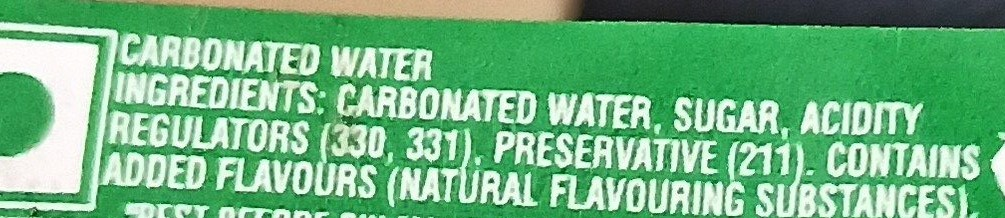

In [23]:
# Local: Running Float16 Quantization
tflite_output = run_tflite_model(image_path, 'float16')
final_output = "".join(alphabets[index] for index in tflite_output[0] if index not in [blank_index, -1])
print(final_output)
Image(filename=image_path)